# Library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50,resnet152
from PIL import Image
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import cv2
import albumentations as A
# import warnings
# warnings.filterwarnings('ignore')


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_r=pd.read_csv('/content/drive/MyDrive/data/train_r.csv')
train_p=pd.read_csv('/content/drive/MyDrive/data/train_p.csv')
valid_r=pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')
valid_p=pd.read_csv('/content/drive/MyDrive/data/valid_p.csv')

test_r=pd.read_csv('/content/drive/MyDrive/data/test_r.csv')
test_p=pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

In [5]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

#Config

In [7]:
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#batch size
batch_size = 16

# params
epoch = 20
patience = 2
factor = 0.5
# loss function
loss_fn = nn.CrossEntropyLoss().to(device)

bert_lr = 2e-5
max_length=256
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

res_lr = 0.001
transformers = transforms=A.Compose(
            [A.Resize(255, 255, always_apply=True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)])

n_train_p=len(train_p)
n_valid_p=len(valid_p)
n_train_r=len(train_r)
n_valid_r=len(valid_r)

train_img_p = '/content/drive/MyDrive/data/train_P_image/'
test_img_p = '/content/drive/MyDrive/data/test_P_image/'

train_img_r = '/content/drive/MyDrive/data/train_R_image/'
test_img_r = '/content/drive/MyDrive/data/test_R_image/'


In [8]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Model

In [9]:
class MultiDataSet(Dataset):
    def __init__(self, img_names, img_dir, text, target, tokenizer, transforms):
      super(MultiDataSet, self).__init__()
      self.img_names = img_names+'.jpg'
      self.img_dir = img_dir
      self.text = list(text)
      self.target = target
      self.tokenizer= tokenizer
      self.transforms = transforms
      self.encoded_captions = tokenizer(
            self.text, padding=True, truncation=True, max_length=max_length
        )

    def __getitem__(self, index):
      item = { key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()}
      image = cv2.imread(f"{self.img_dir}{self.img_names[index]}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transforms(image=image)['image']
      item['target'] = self.target[index]
      item['image'] = torch.tensor(image).permute(2, 0, 1).float()

      return item

    def __len__(self):
      return len(self.text)


def create_multi_loader(df, img_dir, shuffle):
    ds = MultiDataSet(text=df['text'].values,
                      target=df['index'].values,
                      img_names= df['file_name'].values,
                      img_dir=img_dir,
                      tokenizer=tokenizer,
                      transforms=transforms)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)

In [10]:
class Bert(nn.Module):

  def __init__(self, text_model_path):
    super(Bert, self).__init__()
    self.bert = torch.load(text_model_path)
    self.bert.load_state_dict(self.bert.state_dict())

  def forward(self, input_ids, attention_mask):
    output=self.bert(input_ids=input_ids,attention_mask=attention_mask)
    return output

In [11]:
class Resnet152(nn.Module):

  def __init__(self,audio_model_path):
    super(Resnet152, self).__init__()
    self.model = torch.load(audio_model_path)

  def forward(self, image):
    out = self.model(image)
    return out

class Resnet50(nn.Module):

  def __init__(self,audio_model_path):
    super(Resnet50, self).__init__()
    self.model = torch.load(audio_model_path)

  def forward(self, image):
    out = self.model(image)

    return out

In [12]:
class AudioTextModel(nn.Module):
    def __init__(self, num_classes, text_model_path, audio_model_path):
        super(AudioTextModel, self).__init__()
        self.num_classes=num_classes

        self.text_model=Bert(text_model_path)
        self.audio_model=Resnet152(audio_model_path)

        for param in self.text_model.parameters():
          param.requires_grad = True
        for param in self.audio_model.parameters():
          param.requires_grad = True

        self.dropout = nn.Dropout(.5)
        self.fc1 = nn.Linear(2816,num_classes)
        # self.fc2 = nn.Linear(1200,600)
        # self.fc3 = nn.Linear(600,300)
        # self.fc4 = nn.Linear(300,num_classes)

    def forward(self,input_ids,attention_mask,audio):
        output=self.text_model(input_ids, attention_mask)
        last_hidden_state = output.last_hidden_state
        outputs_text=last_hidden_state[:, 0, :]

        outputs_audio=self.audio_model(audio)
        outputs_audio=outputs_audio.flatten(1)

        concat_embded=torch.cat((outputs_text,outputs_audio),1)
        preds = self.fc1(self.dropout(concat_embded))
        # l2 = self.fc2(l1)
        # l3 = self.fc3(l2)
        # preds = self.fc4(l3)
        return preds

In [13]:
def train_epoch(model, trainloader,optimizer,n_train):
    model=model.train()
    losses=[]
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for batch in process_bar:
        optimizer.zero_grad()
        targets=batch['target'].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        audio=batch['image'].to(device)

        output = model(input_ids,attention_mask,audio)
        _, preds = torch.max(output, dim=1)
        loss = loss_fn(output, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model=model.eval() # puts the model in validation mode
    loss_val = 0.0
    correct_val = 0
    process_bar = tqdm(val_dataloader)
    for batch in process_bar:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)

      outputs = model(input_ids,attention_mask,audio)
      loss = loss_fn(outputs, targets)
      _, preds = torch.max(outputs, dim=1)

      correct_val += (preds == targets).sum().item()
      loss_val += loss.item()

      process_bar.set_postfix(val_loss=loss.item())

    avg_loss_val = loss_val / n_valid
    avg_acc_val = correct_val /n_valid

    return avg_acc_val,avg_loss_val

def get_predictions(model, testloader):
    model=model.eval()

    predictions = []
    real_values = []
    for d in testloader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["target"].to(device)
        audio=d['image'].to(device)

        outputs = model(
            input_ids,attention_mask,audio
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(label)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

# Research

In [14]:
train_dataloader = create_multi_loader(train_r, train_img_r, shuffle=True)
val_dataloader = create_multi_loader(valid_r, test_img_r ,shuffle=False)
test_dataloader = create_multi_loader(test_r, test_img_r ,shuffle=False)

In [15]:
text_model_path='/content/drive/MyDrive/Model/R_text_model.pt'
audio_model_path='/content/drive/MyDrive/Model/R_res152.pt'

model=AudioTextModel(5, text_model_path, audio_model_path).to(device)
params = [
    {"params": model.text_model.parameters(), "lr": bert_lr},
    {"params": model.audio_model.parameters(), "lr": res_lr} ]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

In [16]:
for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_r)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_r)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_multi_pretrained.pt')

Epoch 1/20
----------


100%|██████████| 114/114 [10:35<00:00,  5.58s/it, train_loss=0.00838]


Train loss 0.18459214777440616 accuracy 0.9499449944994499


100%|██████████| 15/15 [01:19<00:00,  5.32s/it, val_loss=1.26]


Val loss 0.1101266788808923 accuracy 0.6228070175438597

Epoch 2/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.32it/s, train_loss=0.00489]


Train loss 0.013422319222356012 accuracy 0.9977997799779977


100%|██████████| 15/15 [00:02<00:00,  7.00it/s, val_loss=0.00597]


Val loss 0.12255236545879916 accuracy 0.6359649122807017

Epoch 3/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.30it/s, train_loss=0.00108]


Train loss 0.007977142959645247 accuracy 0.9977997799779977


100%|██████████| 15/15 [00:02<00:00,  7.00it/s, val_loss=1.49]


Val loss 0.12824007973336338 accuracy 0.618421052631579

Epoch 4/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.33it/s, train_loss=0.006]


Train loss 0.0035512476762258366 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:02<00:00,  6.94it/s, val_loss=0.00244]


Val loss 0.15170091452697912 accuracy 0.631578947368421

Epoch 5/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.32it/s, train_loss=0.00296]


Train loss 0.0037312715859642545 accuracy 0.9994499449944994


100%|██████████| 15/15 [00:02<00:00,  7.07it/s, val_loss=0.0719]


Val loss 0.12860802770183796 accuracy 0.631578947368421

Epoch 6/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.00229]


Train loss 0.0016955514208683254 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.83it/s, val_loss=0.0837]


Val loss 0.12793925554867377 accuracy 0.6271929824561403

Epoch 7/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000954]


Train loss 0.0010999850328836035 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.88it/s, val_loss=0.206]


Val loss 0.1302550262526462 accuracy 0.6403508771929824

Epoch 8/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000507]


Train loss 0.0007396085831651202 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.07it/s, val_loss=0.0825]


Val loss 0.13053901624261288 accuracy 0.631578947368421

Epoch 9/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000138]


Train loss 0.0005282363976891103 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.01it/s, val_loss=0.106]


Val loss 0.13298303176436507 accuracy 0.6271929824561403

Epoch 10/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.00108]


Train loss 0.0003991054370744039 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.07it/s, val_loss=0.211]


Val loss 0.13473434948868918 accuracy 0.6228070175438597

Epoch 11/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.33it/s, train_loss=0.000185]


Train loss 0.0003233428736469553 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.07it/s, val_loss=0.206]


Val loss 0.13482126064206423 accuracy 0.6228070175438597

Epoch 12/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.00025]


Train loss 0.00026808015364191594 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.98it/s, val_loss=0.2]


Val loss 0.13720642252449403 accuracy 0.6271929824561403

Epoch 13/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000346]


Train loss 0.00022871799384965765 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.85it/s, val_loss=0.273]


Val loss 0.1367048587192569 accuracy 0.6271929824561403

Epoch 14/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000191]


Train loss 0.00020658562202139334 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.14it/s, val_loss=0.185]


Val loss 0.1373495292245296 accuracy 0.6271929824561403

Epoch 15/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=0.000231]


Train loss 0.00016113471470465842 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.92it/s, val_loss=0.104]


Val loss 0.13820137603110388 accuracy 0.618421052631579

Epoch 16/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.33it/s, train_loss=0.000801]


Train loss 0.00017060259230212277 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.02it/s, val_loss=0.185]


Val loss 0.13932673992556438 accuracy 0.618421052631579

Epoch 17/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.33it/s, train_loss=4.89e-5]


Train loss 0.0001484051643178406 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  7.02it/s, val_loss=0.183]


Val loss 0.1389216534924089 accuracy 0.6228070175438597

Epoch 18/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.33it/s, train_loss=0.000113]


Train loss 0.00012206464167288607 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.99it/s, val_loss=0.184]


Val loss 0.1408590625383352 accuracy 0.6140350877192983

Epoch 19/20
----------


100%|██████████| 114/114 [00:49<00:00,  2.32it/s, train_loss=4.07e-5]


Train loss 0.00013135274232473946 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.95it/s, val_loss=0.148]


Val loss 0.1409488497465326 accuracy 0.6140350877192983

Epoch 20/20
----------


100%|██████████| 114/114 [00:48<00:00,  2.34it/s, train_loss=4.05e-5]


Train loss 0.00011343370741151535 accuracy 1.0


100%|██████████| 15/15 [00:02<00:00,  6.86it/s, val_loss=0.179]


Val loss 0.13922407700304398 accuracy 0.618421052631579



In [17]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

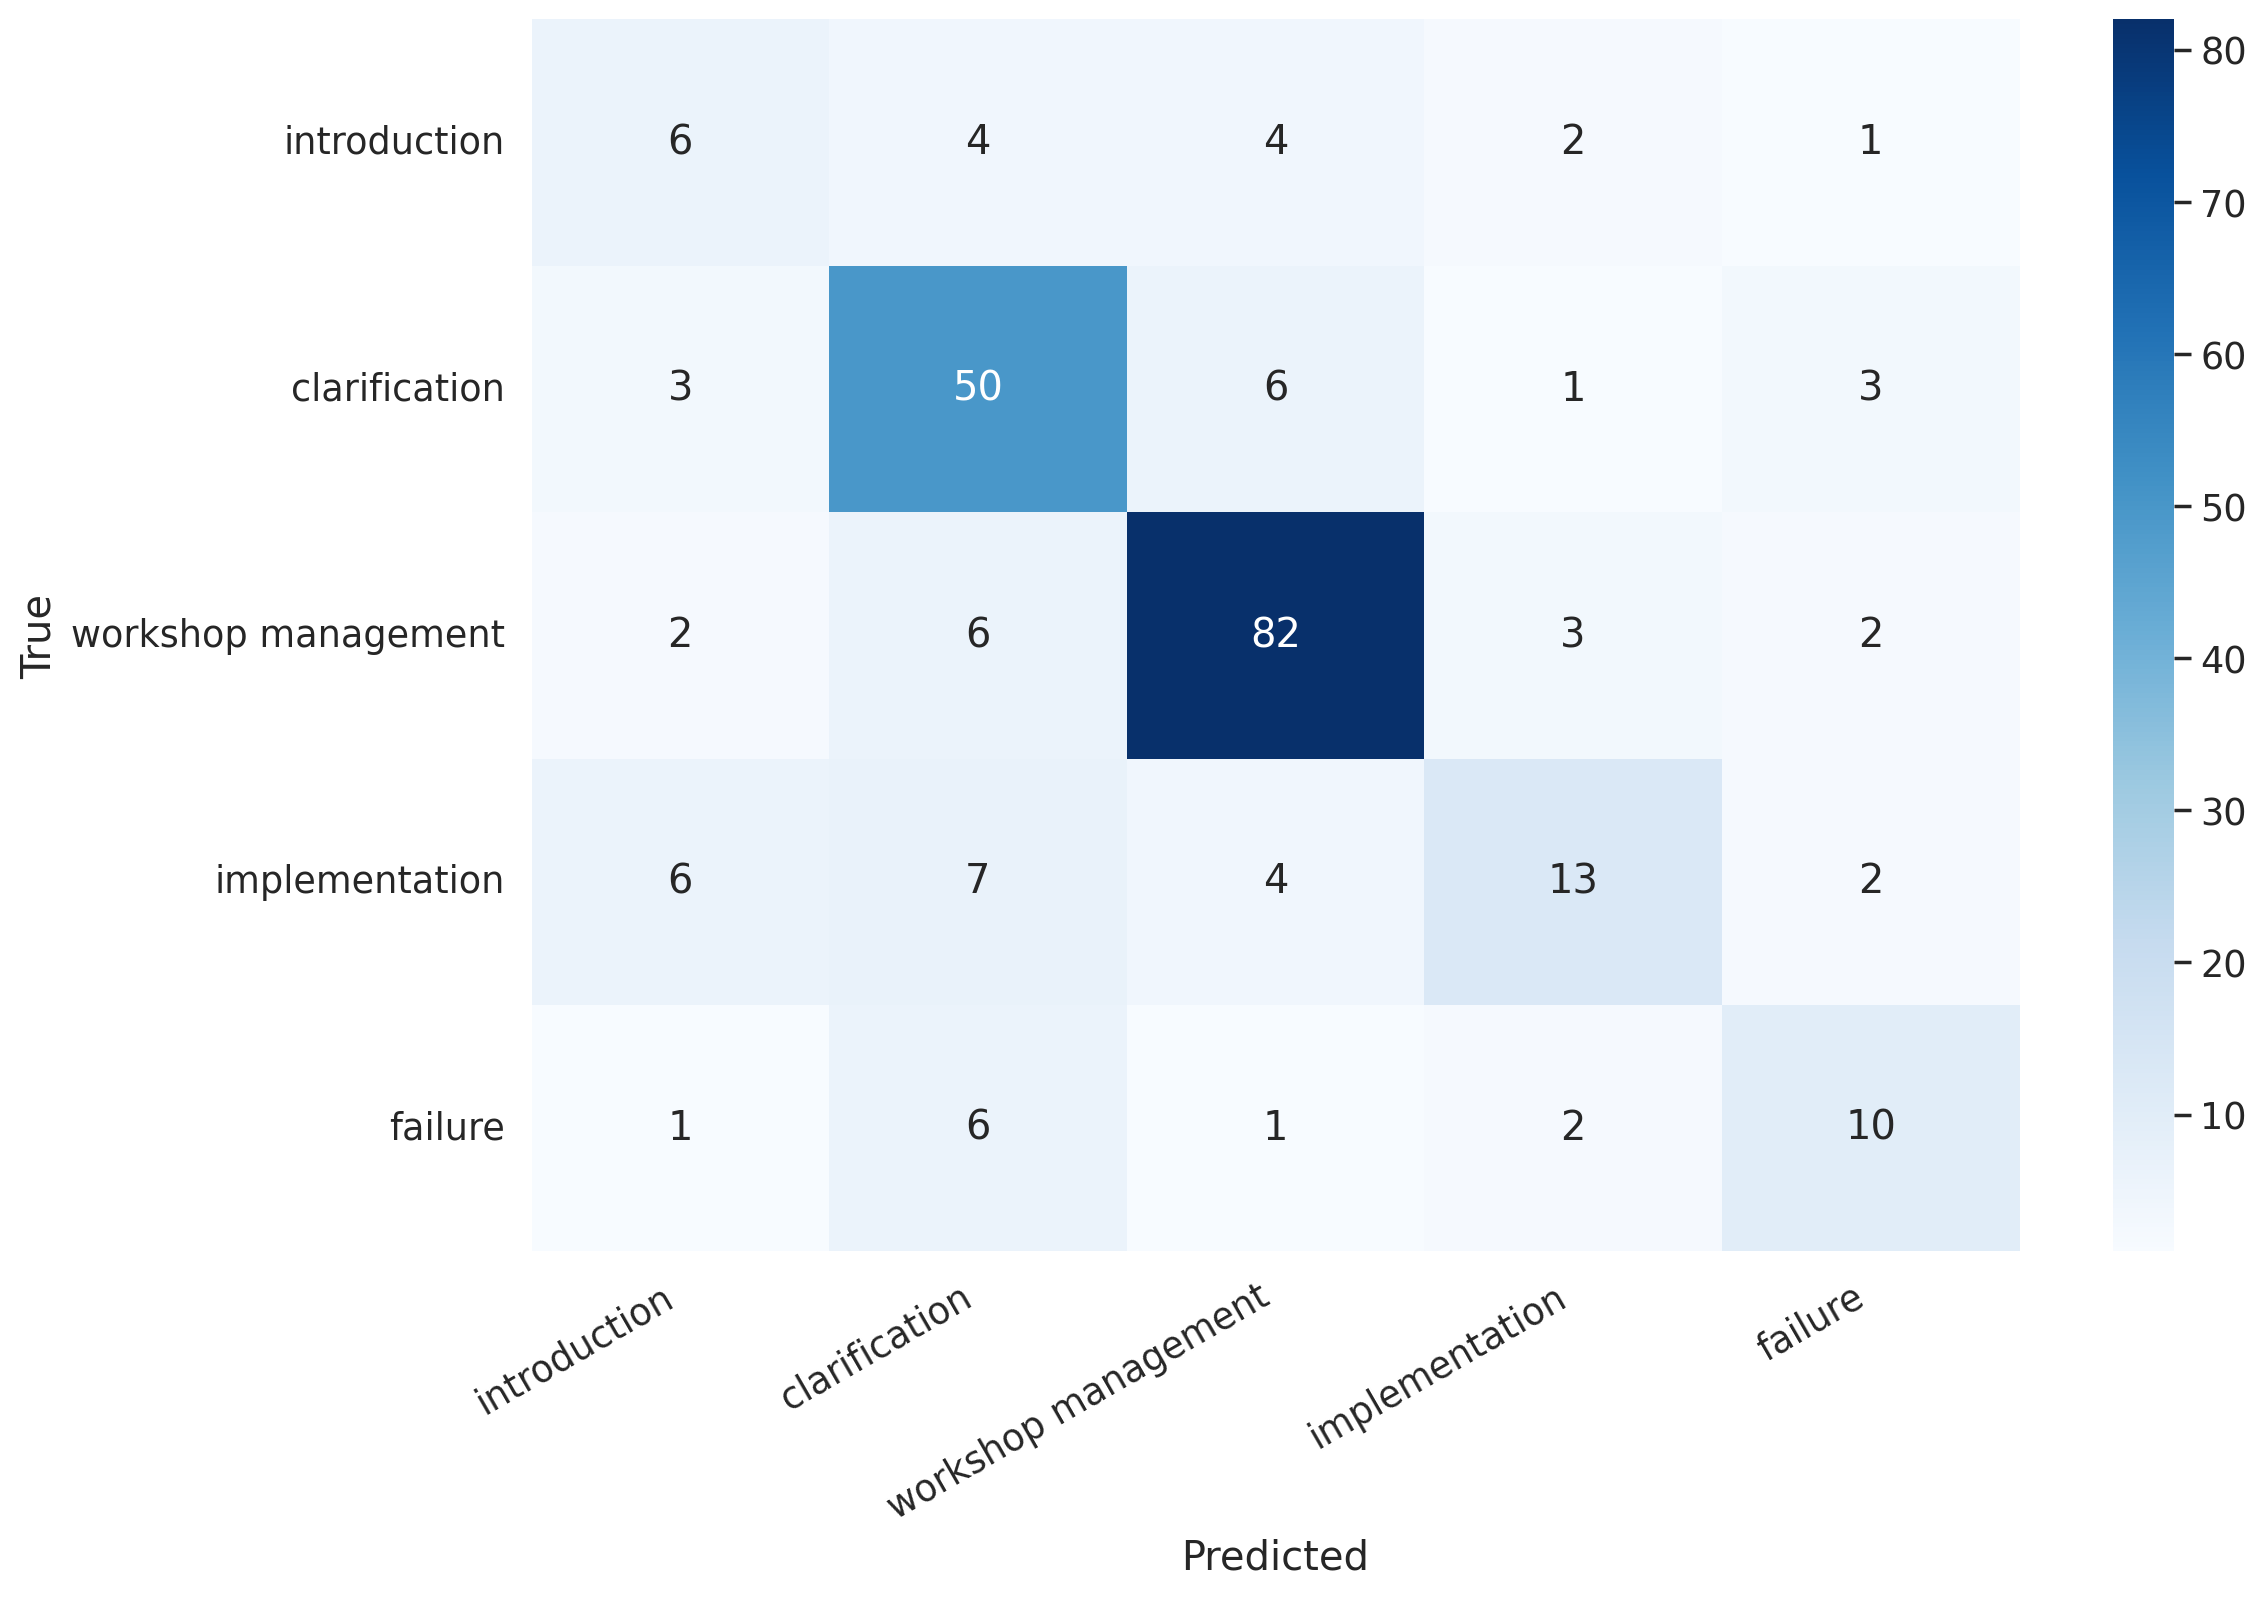

In [18]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [19]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.33      0.35      0.34        17
      clarification       0.68      0.79      0.74        63
workshop management       0.85      0.86      0.85        95
     implementation       0.62      0.41      0.49        32
            failure       0.56      0.50      0.53        20

           accuracy                           0.71       227
          macro avg       0.61      0.58      0.59       227
       weighted avg       0.71      0.71      0.70       227



# Participant

In [20]:
train_dataloader = create_multi_loader(train_p, train_img_p, shuffle=True)
val_dataloader = create_multi_loader(valid_p, test_img_p ,shuffle=False)
test_dataloader = create_multi_loader(test_p, test_img_p ,shuffle=False)

In [21]:
text_model_path='/content/drive/MyDrive/Model/P_text_model.pt'
audio_model_path='/content/drive/MyDrive/Model/P_res50.pt'

model=AudioTextModel(5, text_model_path, audio_model_path).to(device)
params = [
    {"params": model.text_model.parameters(), "lr": bert_lr},
    {"params": model.audio_model.parameters(), "lr": res_lr} ]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

In [22]:
for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_p)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_p)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_multi_pretrained.pt')


Epoch 1/20
----------


100%|██████████| 91/91 [08:47<00:00,  5.80s/it, train_loss=0.0158]


Train loss 0.23165863688912366 accuracy 0.9399585921325052


100%|██████████| 12/12 [01:05<00:00,  5.44s/it, val_loss=1.93]


Val loss 0.16125828355223268 accuracy 0.5

Epoch 2/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.00324]


Train loss 0.017148173869597716 accuracy 0.9951690821256038


100%|██████████| 12/12 [00:01<00:00,  8.70it/s, val_loss=2.44]


Val loss 0.18642398485770592 accuracy 0.46703296703296704

Epoch 3/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.00472]


Train loss 0.0057975855748077015 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  8.67it/s, val_loss=2.5]


Val loss 0.19972131933484757 accuracy 0.43956043956043955

Epoch 4/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.00225]


Train loss 0.007375283948411899 accuracy 0.9993098688750863


100%|██████████| 12/12 [00:01<00:00,  8.61it/s, val_loss=2.84]


Val loss 0.20697701370323096 accuracy 0.46703296703296704

Epoch 5/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.00408]


Train loss 0.002642534153822523 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.61it/s, val_loss=2.84]


Val loss 0.2055207955968249 accuracy 0.45604395604395603

Epoch 6/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.00356]


Train loss 0.0017340948842312362 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.79it/s, val_loss=3.23]


Val loss 0.21043174607413156 accuracy 0.45054945054945056

Epoch 7/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.000296]


Train loss 0.0010083699534943961 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.95it/s, val_loss=3.41]


Val loss 0.2154238224029541 accuracy 0.44505494505494503

Epoch 8/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.000683]


Train loss 0.0005662826989754359 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.88it/s, val_loss=3.42]


Val loss 0.22242930695250795 accuracy 0.43956043956043955

Epoch 9/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000799]


Train loss 0.0004204655493734978 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.99it/s, val_loss=3.63]


Val loss 0.22643107241326635 accuracy 0.42857142857142855

Epoch 10/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000108]


Train loss 0.0003212639799080584 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.68it/s, val_loss=3.71]


Val loss 0.22597758324591669 accuracy 0.4340659340659341

Epoch 11/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000282]


Train loss 0.00026956474567459035 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  9.00it/s, val_loss=3.66]


Val loss 0.22950772662739177 accuracy 0.42857142857142855

Epoch 12/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.92it/s, train_loss=0.000255]


Train loss 0.0002350621391567504 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.82it/s, val_loss=3.84]


Val loss 0.23292169597122694 accuracy 0.42857142857142855

Epoch 13/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.89it/s, train_loss=0.00015]


Train loss 0.00016969662301362604 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.65it/s, val_loss=3.81]


Val loss 0.23450367660312862 accuracy 0.43956043956043955

Epoch 14/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000103]


Train loss 0.00016476192376013477 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.74it/s, val_loss=3.76]


Val loss 0.2344648628444462 accuracy 0.42857142857142855

Epoch 15/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.90it/s, train_loss=0.000801]


Train loss 0.00018052795288955108 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.72it/s, val_loss=3.82]


Val loss 0.2364121871990162 accuracy 0.42857142857142855

Epoch 16/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000139]


Train loss 0.0001520274523939876 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.76it/s, val_loss=3.86]


Val loss 0.23338490921062427 accuracy 0.4340659340659341

Epoch 17/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=4.71e-5]


Train loss 0.00014347594321237182 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.56it/s, val_loss=3.83]


Val loss 0.23351010254451207 accuracy 0.43956043956043955

Epoch 18/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.90it/s, train_loss=6.06e-5]


Train loss 0.00013307859748298083 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.98it/s, val_loss=3.84]


Val loss 0.23357896359412225 accuracy 0.43956043956043955

Epoch 19/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000213]


Train loss 0.00012428045588571727 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  8.87it/s, val_loss=3.85]


Val loss 0.23522111085745004 accuracy 0.43956043956043955

Epoch 20/20
----------


100%|██████████| 91/91 [00:31<00:00,  2.91it/s, train_loss=0.000167]


Train loss 0.00013728238341822622 accuracy 1.0


100%|██████████| 12/12 [00:01<00:00,  9.02it/s, val_loss=3.79]


Val loss 0.23586763654436385 accuracy 0.4340659340659341



In [23]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

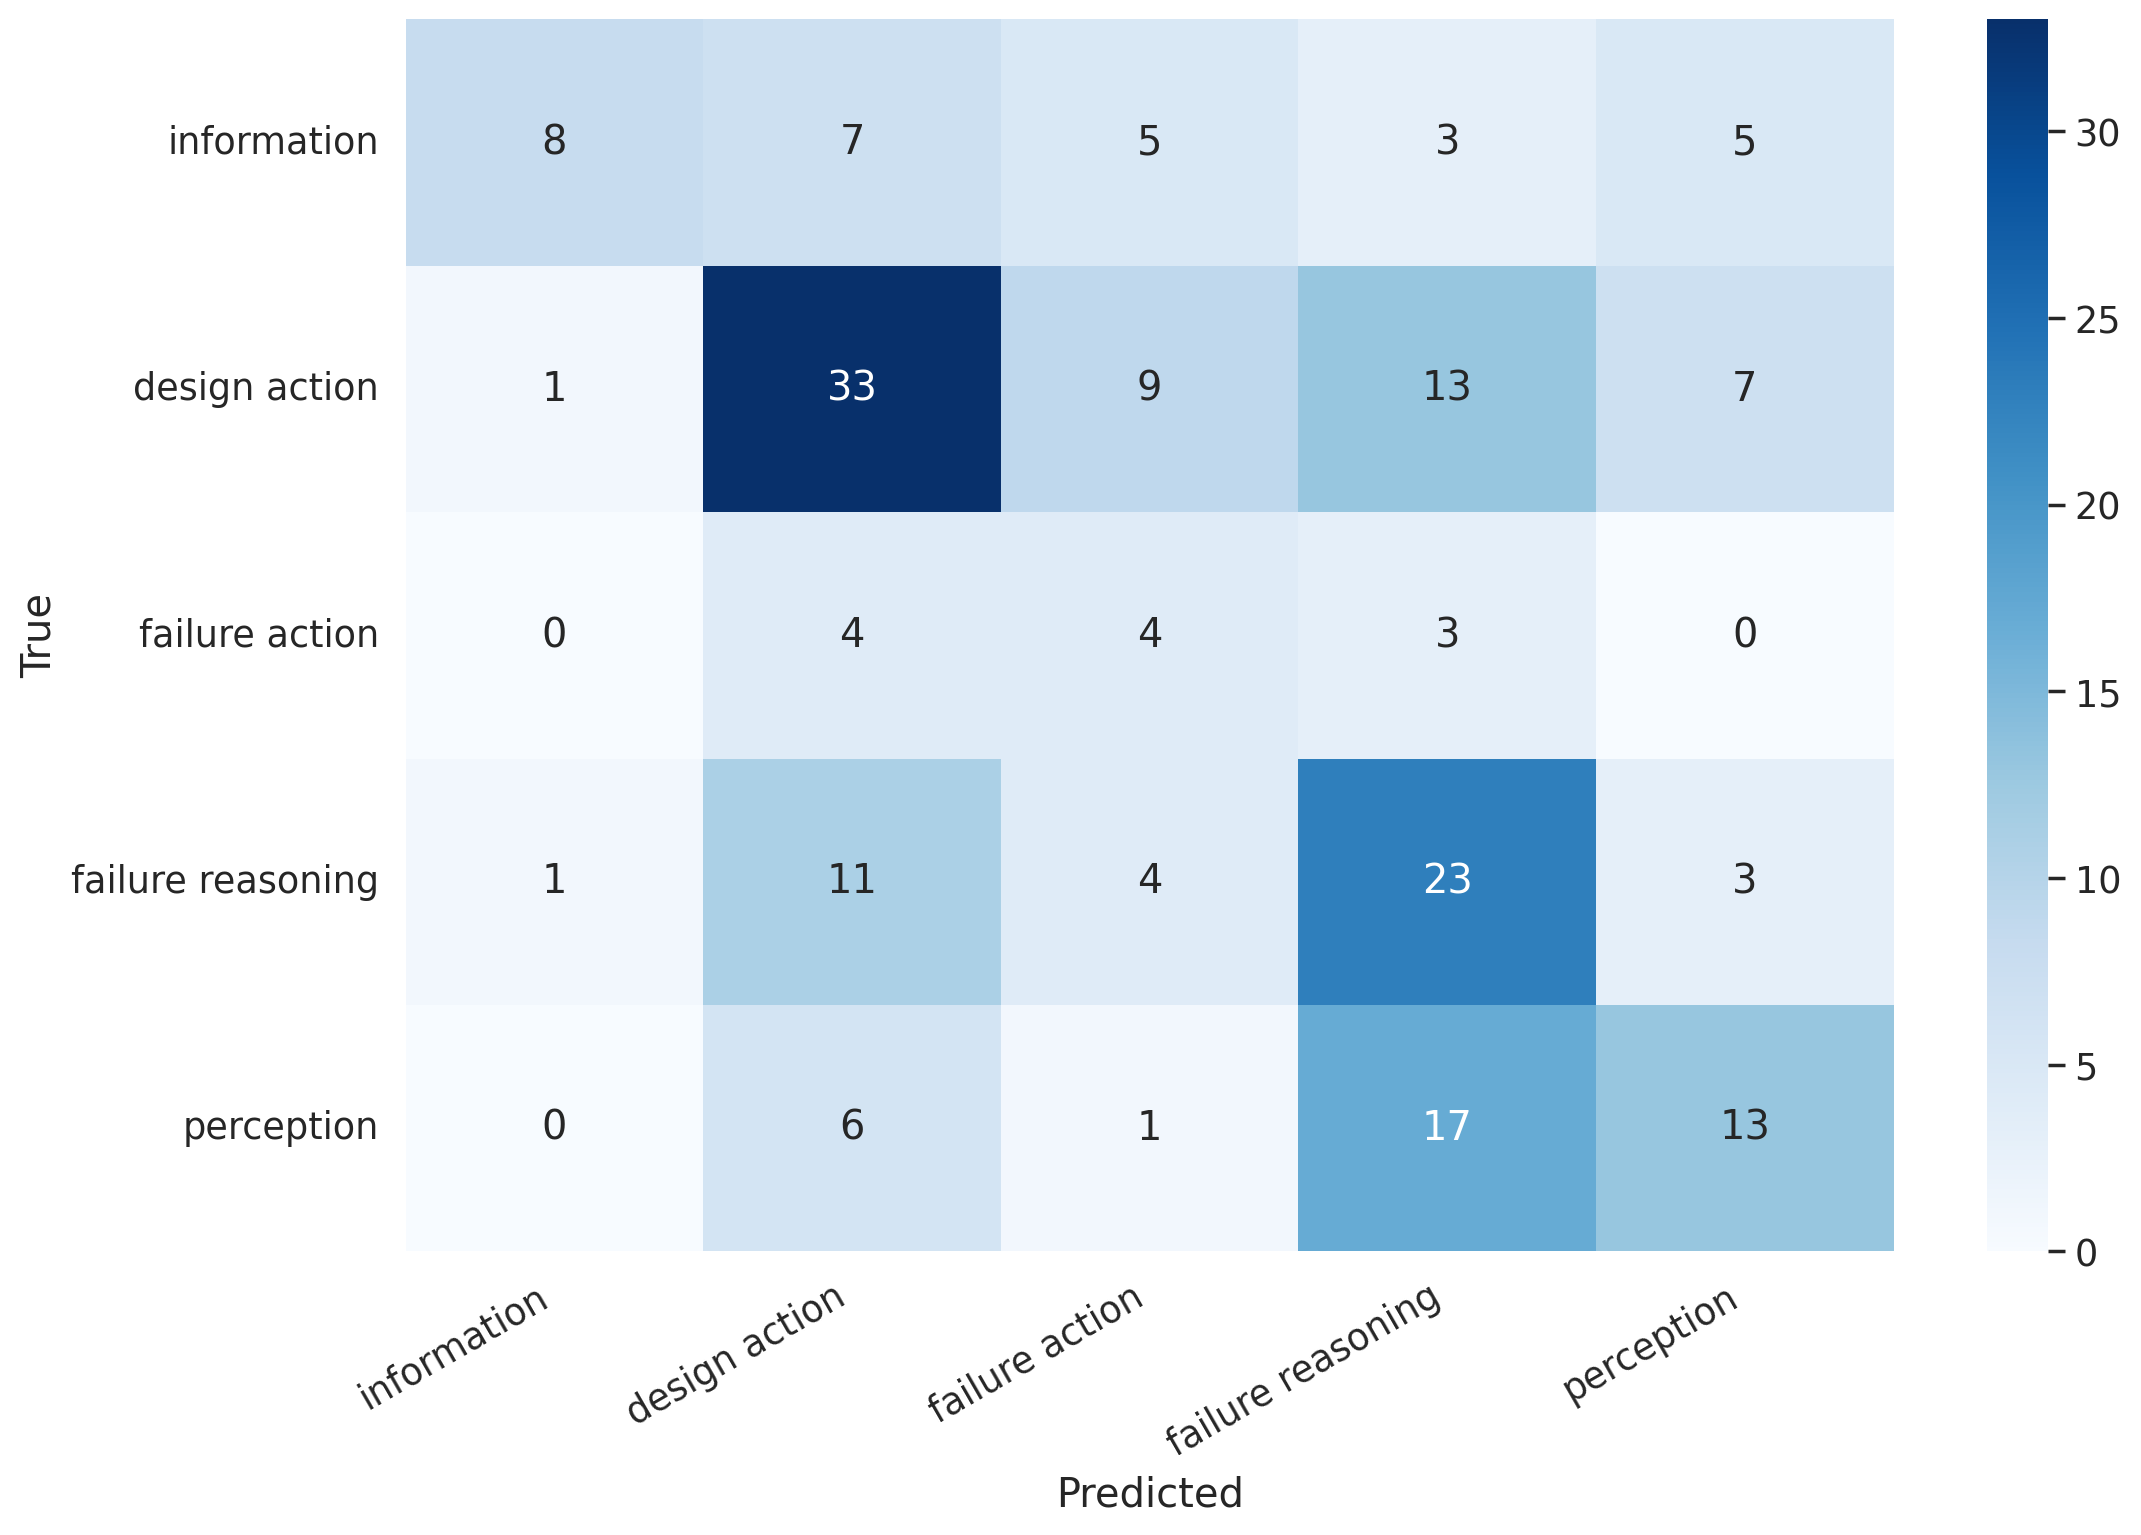

In [24]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [25]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.80      0.29      0.42        28
    design action       0.54      0.52      0.53        63
   failure action       0.17      0.36      0.24        11
failure reasoning       0.39      0.55      0.46        42
       perception       0.46      0.35      0.40        37

         accuracy                           0.45       181
        macro avg       0.47      0.41      0.41       181
     weighted avg       0.51      0.45      0.45       181

